In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_colwidth', None) # full column width
pd.set_option('display.max_rows', None) # display all rows

## File sizes

In [3]:
sizes_df = pd.read_csv('sizes.csv', names=['size', 'file'])

In [4]:
sizes_df['file'] = sizes_df['file'].apply(lambda x: x.split('/')[-1])

In [5]:
substrings_to_filter = [".xes.bench.xes", ".gz"]
pattern = '|'.join(substrings_to_filter)
sizes_df = sizes_df[~sizes_df['file'].str.contains(pattern, case=False, na=False)]
sizes_df = sizes_df[~sizes_df['file'].str.endswith(".jxes")]

In [6]:
sizes_df = sizes_df.sort_values(by='file')

In [7]:
sizes_df.reset_index(drop=True, inplace=True)

In [8]:
sizes_df['size_kb'] = sizes_df['size'] / 1024  # Convert size from bytes to kilobytes
sizes_df['size_mb'] = sizes_df['size_kb'] / 1024  # Convert size from kilobytes to megabytes

In [9]:
replacements = {
    '2020_DomesticDeclarations': '2020_Domestic',
    '2020_InternationalDeclarations': '2020_International',
    '2020_PermitLog': '2020_Permit',
    '2020_PrepaidTravelCost': '2020_Prepaid',
    '2020_RequestForPayment': '2020_Request',
    'BPIC15_': '2015_',
    'BPI_Challenge_': '',
    'Hospital_log': '2011',
    'financial_log': '2012',
    'bpi_challenge_2013_closed_problems': '2013_Closed',
    'bpi_challenge_2013_incidents': '2013_Incidents',
    'bpi_challenge_2013_open_problems': '2013_Open',
    'Road_Traffic_Fine_Management_Process': 'Road_Traffic',
    'helpdesk': 'Helpdesk'
}

In [10]:
def replace_substrings(text, replacements):
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

In [11]:
sizes_df['file'] = sizes_df['file'].apply(lambda x: replace_substrings(x, replacements))

In [12]:
sizes_df['prefix'] = sizes_df['file'].apply(lambda x: x.split('.xes')[0])

In [13]:
def extract_suffix(file):
    if file.endswith('compare.bench.xes'):
        return '.xes-pm4py'
    elif file.endswith('.xes'):
        return '.xes'
    elif file.endswith('.jxes.bench'):
        return '.jxes'
    else:
        return 'unknown'

In [14]:
sizes_df['suffix'] = sizes_df['file'].apply(extract_suffix)

In [15]:
def calculate_savings(row):
    xes_pm4py_size = row.get('.xes-pm4py', None)
    jxes_size = row.get('.jxes', None)
    if pd.notna(xes_pm4py_size) and pd.notna(jxes_size) and xes_pm4py_size != 0:
        return (xes_pm4py_size - jxes_size) / xes_pm4py_size
    else:
        return None

In [16]:
# Create a list to store storage savings results
savings_list = []

# Calculate storage savings for each group of 'prefix'
for prefix, group in sizes_df.groupby('prefix'):
    savings = calculate_savings(group.set_index('suffix')['size'])
    if savings is not None:
        savings_list.append({'prefix': prefix, 'storage_savings': savings})

# Convert the list of dictionaries to a DataFrame
savings_data = pd.DataFrame(savings_list)

In [17]:
sizes_df = sizes_df.merge(savings_data, on='prefix', how='left')

In [18]:
sizes_df.style.set_properties(subset=['file'], **{'text-align': 'left'})

,size,file,size_kb,size_mb,prefix,suffix,storage_savings
0,20497405,2020_Domestic.xes,20016.997070,19.547849,2020_Domestic,.xes,0.281526
1,20606058,2020_Domestic.xes.compare.bench.xes,20123.103516,19.651468,2020_Domestic,.xes-pm4py,0.281526
2,14804916,2020_Domestic.xes.jxes.bench,14457.925781,14.119068,2020_Domestic,.jxes,0.281526
3,29200127,2020_International.xes,28515.749023,27.847411,2020_International,.xes,0.287970
4,29388076,2020_International.xes.compare.bench.xes,28699.292969,28.026653,2020_International,.xes-pm4py,0.287970
5,20925179,2020_International.xes.jxes.bench,20434.745117,19.955806,2020_International,.jxes,0.287970
6,33249860,2020_Permit.xes,32470.566406,31.709538,2020_Permit,.xes,0.293243
7,33453812,2020_Permit.xes.compare.bench.xes,32669.738281,31.904041,2020_Permit,.xes-pm4py,0.293243
8,23643717,2020_Permit.xes.jxes.bench,23089.567383,22.548406,2020_Permit,.jxes,0.293243
9,7848938,2020_Prepaid.xes,7664.978516,7.485331,2020_Prepaid,.xes,0.281997


In [19]:
plot_data = sizes_df.pivot_table(index='prefix', columns='suffix', values='size', aggfunc='first')

In [20]:
small_files = plot_data[plot_data.max(axis=1) < 150 * 1024 * 1024]
big_files = plot_data[plot_data.max(axis=1) >= 150 * 1024 * 1024]

In [21]:
# Convert sizes to MB and GB
small_files_mb = small_files / (1024 * 1024)
big_files_mb = big_files / (1024 * 1024)
big_files_gb = big_files / (1024 * 1024 * 1024)

In [22]:
def format_with_separator(value):
    return f'{value:,.0f}'.replace(',', '_')

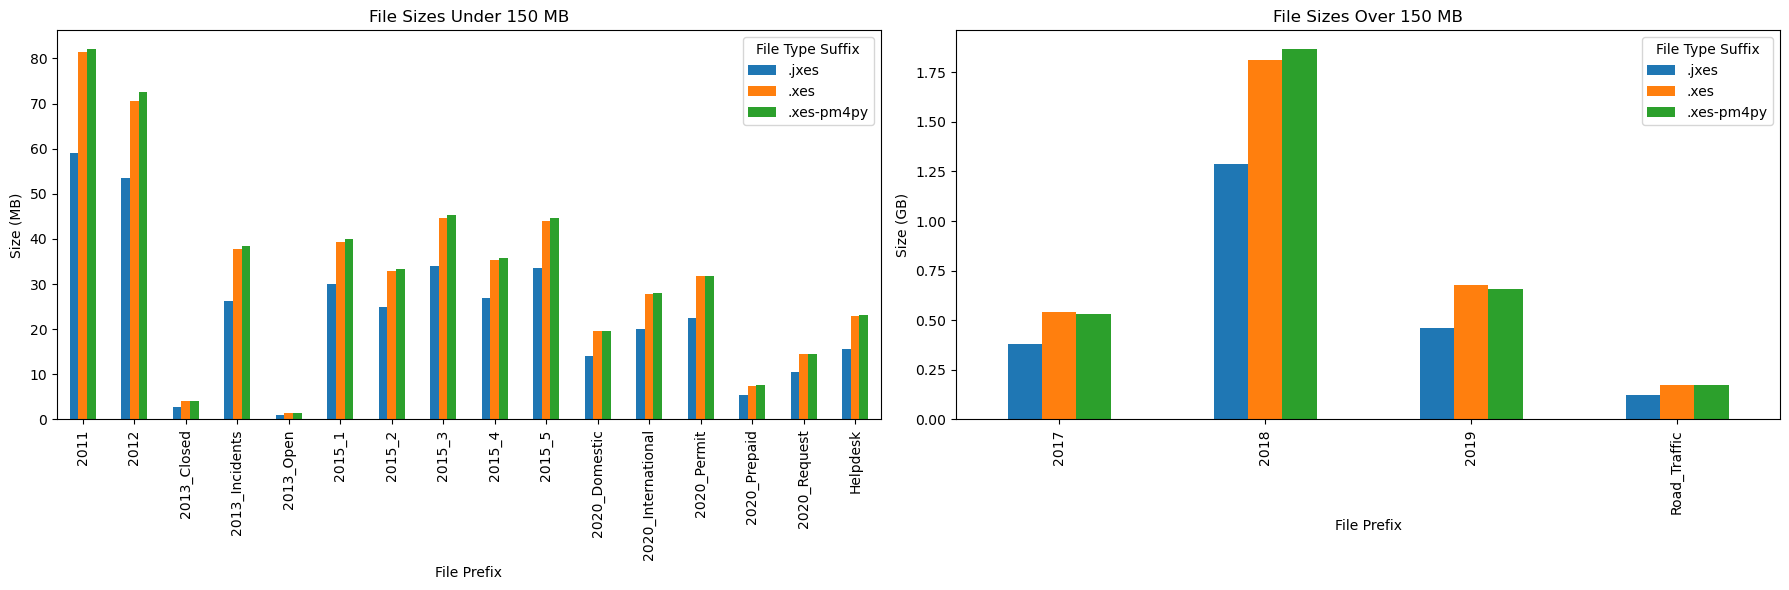

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Files under 150 MB (Sizes in KB)
small_files_mb.plot(kind='bar', ax=axes[0])
axes[0].set_title('File Sizes Under 150 MB')
axes[0].set_xlabel('File Prefix')
axes[0].set_ylabel('Size (MB)')
axes[0].set_xticklabels(small_files_mb.index, rotation=90)
axes[0].legend(title='File Type Suffix')

# Plot 2: Files over 150 MB (Sizes in MB)
big_files_gb.plot(kind='bar', ax=axes[1])
axes[1].set_title('File Sizes Over 150 MB')
axes[1].set_xlabel('File Prefix')
axes[1].set_ylabel('Size (GB)')
axes[1].set_xticklabels(big_files_mb.index, rotation=90)
axes[1].legend(title='File Type Suffix')

plt.tight_layout()
plt.show()

<Figure size 900x600 with 0 Axes>

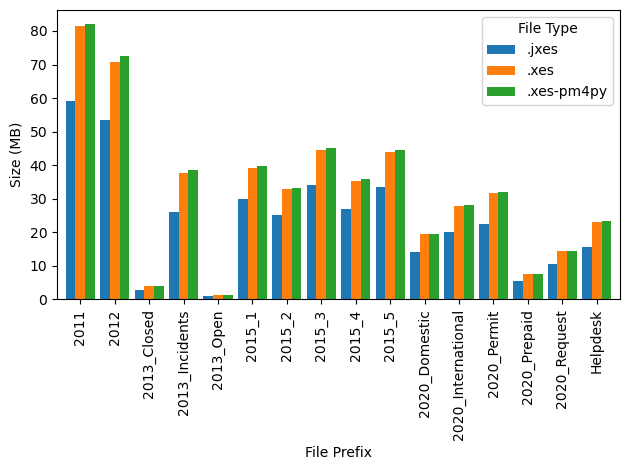

In [24]:
plt.figure(figsize=(9, 6))
small_files_mb.plot(kind='bar', width=0.85)
# plt.title('File Sizes Under 150 MB')
plt.xlabel('File Prefix')
plt.ylabel('Size (MB)')
plt.xticks(rotation=90) 
plt.legend(title='File Type')

# Save the first plot to a file
plt.tight_layout()
plt.savefig('file_sizes_small.png')
plt.show()

<Figure size 900x600 with 0 Axes>

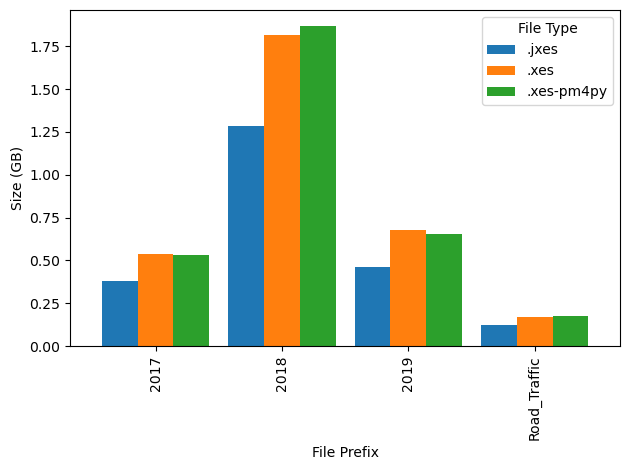

In [25]:
plt.figure(figsize=(9, 6))
big_files_gb.plot(kind='bar', width=0.85)
# plt.title('File Sizes Over 150 MB')
plt.xlabel('File Prefix')
plt.ylabel('Size (GB)')
plt.xticks(rotation=90)
plt.legend(title='File Type')

# Save the second plot to a file
plt.tight_layout()
plt.savefig('file_sizes_big.png')
plt.show()

In [26]:
sizes_df.drop_duplicates('prefix')['storage_savings'].agg(['min', 'max', 'mean', 'median'])

min      0.2478
max      0.3322
mean     0.2844
median   0.2824
Name: storage_savings, dtype: float64

<Figure size 1200x1000 with 0 Axes>

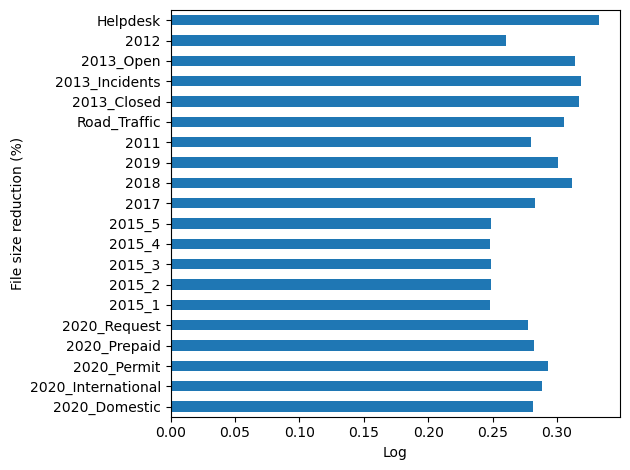

In [27]:
plt.figure(figsize=(12, 10))

sizes_df.drop_duplicates('prefix').plot(kind='barh', x='prefix', y='storage_savings', legend=False)

# plt.title('File Size Reduction (xes-pm4py vs. jxes)')
plt.xlabel('Log')
plt.ylabel('File size reduction (%)')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.savefig('storage_savings.png')
plt.show()

## Read and write performance

In [28]:
speed_df = pd.read_csv('benchmark_results_full.csv', header=0)

In [29]:
speed_df = speed_df[~speed_df['File'].str.contains(pattern, case=False, na=False)]

In [30]:
speed_df['File'] = speed_df['File'].apply(lambda x: replace_substrings(x.split('/')[-1], replacements))

In [31]:
speed_df['Time_ms'] = speed_df['Time'] / 1e6  # Convert to milliseconds

In [32]:
speed_df['Prefix'] = speed_df['File'].apply(lambda x: x.split('.')[0])

In [33]:
summary_df = speed_df.groupby(['Operation', 'Prefix', 'Configuration']).agg(
    min_time=('Time_ms', 'min'),
    mean_time=('Time_ms', 'mean'),
    median_time=('Time_ms', 'median'),
    max_time=('Time_ms', 'max')
).reset_index().dropna()

In [34]:
# Filter out rows that produce no log
summary_df = summary_df[
    ~(
        summary_df['Prefix'].str.contains('2017|2019') &  # Contains 2017 or 2019
        (summary_df['Configuration'] == 'line_by_line') &  # Configuration is 'line_by_line'
        (summary_df['Operation'].str.contains('read'))  # Operation is 'read'
    )
]

In [35]:
summary_df.style.set_properties(subset=['Prefix'], **{'text-align': 'left'})

,Operation,Prefix,Configuration,min_time,mean_time,median_time,max_time
1,read_pm4py,2011,iterparse,14588.717977,15048.021988,15168.585008,15495.904198
2,read_pm4py,2011,iterparse_20,14658.598234,15017.821666,15117.807413,15341.685682
3,read_pm4py,2011,iterparse_mem_compressed,15408.393392,15680.904067,15564.984543,16125.513078
4,read_pm4py,2011,line_by_line,2968.033563,2988.917752,2984.982585,3018.709453
6,read_pm4py,2012,iterparse,12747.123625,13001.390552,12835.684114,13481.925953
7,read_pm4py,2012,iterparse_20,12813.548032,13080.411585,13063.119012,13615.093084
8,read_pm4py,2012,iterparse_mem_compressed,13104.844185,13338.390734,13191.953438,13648.352853
9,read_pm4py,2012,line_by_line,3104.269779,3119.505441,3116.707880,3141.053321
10,read_pm4py,2013_Closed,chunk_regex,243.136384,245.860049,244.137934,249.739236
11,read_pm4py,2013_Closed,iterparse,735.205498,747.767686,750.432781,755.713832


In [36]:
# Filter the summary DataFrame for read and write operations separately
read_df = summary_df[summary_df['Operation'].str.contains('read')]
write_df = summary_df[summary_df['Operation'].str.contains('write')]

In [37]:
# Create new DataFrames to find the best PM4Py configuration for read and write
pm4py_read_df = read_df[read_df['Configuration'] != 'jxes']
pm4py_write_df = write_df[write_df['Configuration'] != 'jxes']

In [38]:
# Find the minimum median time for PM4Py read and write for each file
best_pm4py_read = pm4py_read_df.loc[pm4py_read_df.groupby('Prefix')['median_time'].idxmin()]
best_pm4py_write = pm4py_write_df.loc[pm4py_write_df.groupby('Prefix')['median_time'].idxmin()]

In [39]:
# Filter jxes results for read and write
jxes_read = read_df[read_df['Configuration'] == 'jxes']
jxes_write = write_df[write_df['Configuration'] == 'jxes']

In [40]:
# Calculate percentage differences for read
read_diff_df = jxes_read[['Prefix', 'median_time']].merge(
    best_pm4py_read[['Prefix', 'median_time']], on='Prefix', suffixes=('_jxes', '_pm4py')
)

In [41]:
read_diff_df['difference_percent'] = (read_diff_df['median_time_pm4py'] - read_diff_df['median_time_jxes']) / read_diff_df['median_time_pm4py'] * 100

In [42]:
write_diff_df = jxes_write[['Prefix', 'median_time']].merge(
    best_pm4py_write[['Prefix', 'median_time']], on='Prefix', suffixes=('_jxes', '_pm4py')
)

In [43]:
write_diff_df['difference_percent'] = (write_diff_df['median_time_pm4py'] - write_diff_df['median_time_jxes']) / write_diff_df['median_time_pm4py'] * 100

In [44]:
# Select files with the largest differences
largest_diff_read_file = read_diff_df.loc[read_diff_df['difference_percent'].idxmax()]
largest_diff_write_file = write_diff_df.loc[write_diff_df['difference_percent'].idxmax()]

/tmp/ipykernel_161831/2296209559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_plot_data['median_time_seconds'] = read_plot_data['median_time'] / 1_000


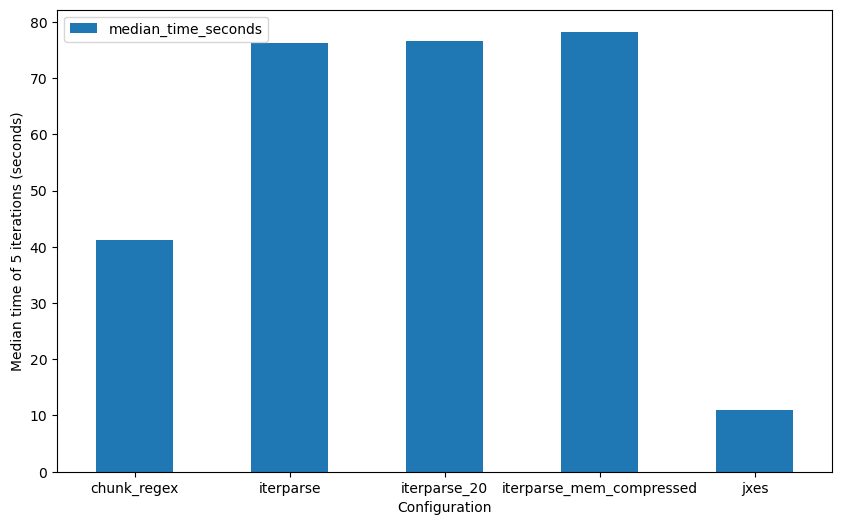

In [45]:
read_plot_data = summary_df[(summary_df['Prefix'] == largest_diff_read_file['Prefix']) & summary_df['Operation'].str.contains('read')]
read_plot_data['median_time_seconds'] = read_plot_data['median_time'] / 1_000
read_plot_data.plot(kind='bar', x='Configuration', y='median_time_seconds', figsize=(10, 6))
# plt.title(f'Read Times for BPIC {largest_diff_read_file["Prefix"]}')
plt.ylabel('Median time of 5 iterations (seconds)')
plt.xlabel('Configuration')
# plt.xticks(rotation=45)
plt.xticks(rotation=0)

plt.savefig('read_best.png')
plt.show()

/tmp/ipykernel_161831/1476796511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_plot_data['median_time_seconds'] = write_plot_data['median_time'] / 1_000


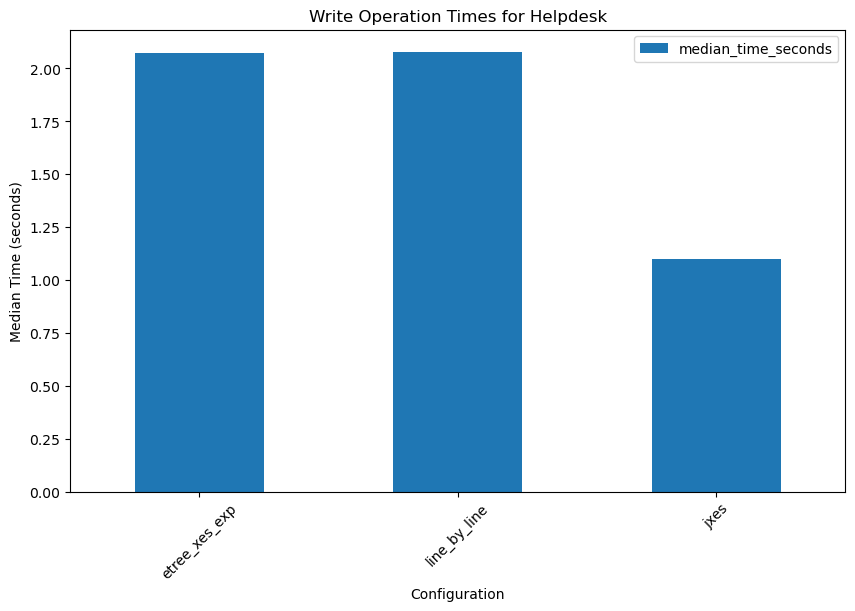

In [46]:
write_plot_data = summary_df[(summary_df['Prefix'] == largest_diff_write_file['Prefix']) & summary_df['Operation'].str.contains('write')]
write_plot_data['median_time_seconds'] = write_plot_data['median_time'] / 1_000
write_plot_data.plot(kind='bar', x='Configuration', y='median_time_seconds', figsize=(10, 6))
plt.title(f'Write Operation Times for {largest_diff_write_file["Prefix"]}')
plt.ylabel('Median Time (seconds)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.show()

In [47]:
# Select files with the smallest differences
smallest_diff_read_file = read_diff_df.loc[read_diff_df['difference_percent'].idxmin()]
smallest_diff_write_file = write_diff_df.loc[write_diff_df['difference_percent'].idxmin()]

/tmp/ipykernel_161831/3021191707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_plot_data_small['median_time_seconds'] = read_plot_data_small['median_time'] / 1_000


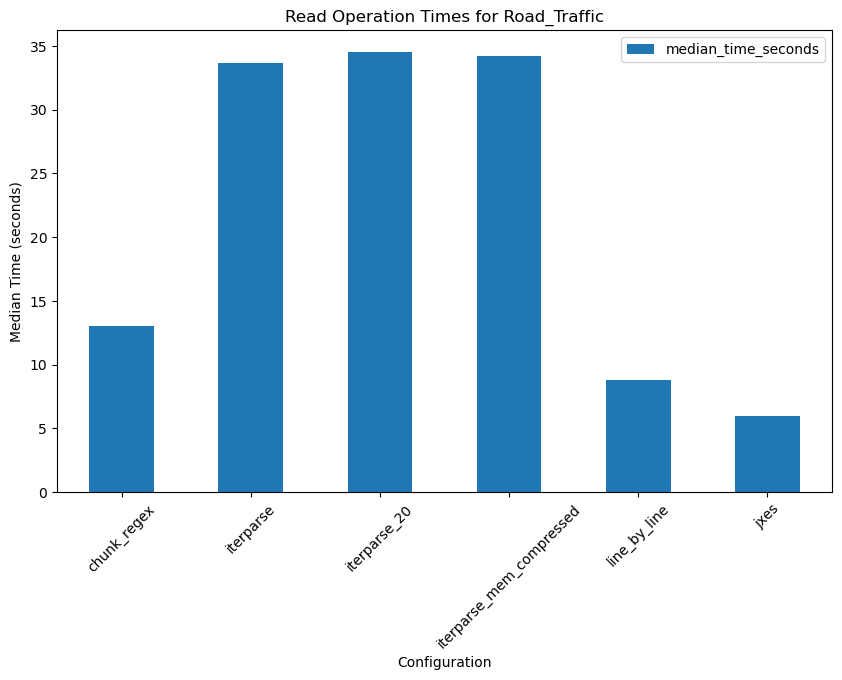

In [48]:
# Bar plot for read
read_plot_data_small = summary_df[(summary_df['Prefix'] == smallest_diff_read_file['Prefix']) & summary_df['Operation'].str.contains('read')]
read_plot_data_small['median_time_seconds'] = read_plot_data_small['median_time'] / 1_000
read_plot_data_small.plot(kind='bar', x='Configuration', y='median_time_seconds', figsize=(10, 6))
plt.title(f'Read Operation Times for {smallest_diff_read_file["Prefix"]}')
plt.ylabel('Median Time (seconds)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_161831/4150026300.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  write_plot_data_small['median_time_seconds'] = write_plot_data_small['median_time'] / 1_000


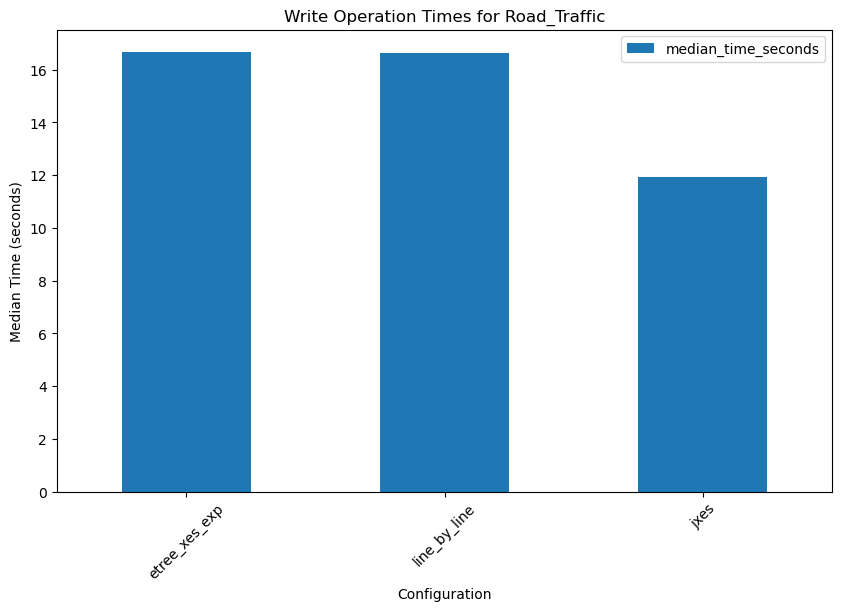

In [49]:
# Bar plot for write
write_plot_data_small = summary_df[(summary_df['Prefix'] == smallest_diff_write_file['Prefix']) & summary_df['Operation'].str.contains('write')]
write_plot_data_small['median_time_seconds'] = write_plot_data_small['median_time'] / 1_000
write_plot_data_small.plot(kind='bar', x='Configuration', y='median_time_seconds', figsize=(10, 6))
plt.title(f'Write Operation Times for {smallest_diff_write_file["Prefix"]}')
plt.ylabel('Median Time (seconds)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.show()

In [50]:
read_difference_stats = read_diff_df['difference_percent'].agg(['min', 'max', 'mean', 'median'])
print("Read Differences Stats:")
print(read_difference_stats)

Read Differences Stats:
min      32.3131
max      73.4062
mean     51.7335
median   52.1927
Name: difference_percent, dtype: float64


In [51]:
write_difference_stats = write_diff_df['difference_percent'].agg(['min', 'max', 'mean', 'median'])
print("\nWrite Differences Stats:")
print(write_difference_stats)


Write Differences Stats:
min      28.3278
max      46.9125
mean     39.1272
median   40.4279
Name: difference_percent, dtype: float64
